# Final Project: Hazardous N.E.O. Classifier

NOTE: A summary will be provided at the bottom of the notebook for ease of grading.

## Objective and Overview

In this notebook, we will be training and evaluating several different models: 3 logistic regression classifiers, 2 SVM classifiers, and a random forest classifier.

Since we are training multiple logistic regression and SVM classifiers, we will identify which performs the best to compare with the other model types.

Our goal is to identify which model type performs best on the dataset in terms of run time and f1-score.

The dataset we will be using is the ["NASA | Nearest Earth Objects (1910-2024)"](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024) dataset from Kaggle. This dataset provides 8 features, and a binary classification as the target label, indicating whether or not the object was deemed "hazardous". A more detailed description is provided in the "Loading and Describing the Dataset" subsection within the "Preparation" section.

## Preparation

### Import necessary libraries and define some helper functions

In [26]:
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

This first function will help load our performance metrics into a `scores` dictionary for easy referencing and plotting.

In [27]:
def allocate_report_metrics(fold: int, scores: dict, report: dict, accuracy, auc):
    scores.setdefault('fold', []).append(fold)
    scores.setdefault('precision', []).append(report['1']['precision'])
    scores.setdefault('recall', []).append(report['1']['recall'])
    scores.setdefault('f1-score', []).append(report['1']['f1-score'])
    scores.setdefault('accuracy', []).append(accuracy)
    scores.setdefault('auc', []).append(auc)

This next function will help us visualize the distributions of our features, and give us an idea of what sort of transformations will be necessary.

In [28]:
def plot_feature_distributions(df_: pd.DataFrame, f_columns):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

    axes = axes.flatten()

    for i, col in enumerate(f_columns):
        sns.histplot(df_[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    
    for i in range(len(f_columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

`plot_performance_metrics` will do as the name implies -- plot our performance metrics for each model, such as accuracy, recall, precision, f1-score, etc. .

In [29]:
from matplotlib.ticker import MaxNLocator

def plot_performance_metrics(model_scores: dict, num_folds: int, sampling: int = 0):
    if len(list(model_scores.values())[0]['fold']) == 1:
        # create a bar plot for each metric
        label, scores = list(model_scores.items())[0]
        df_scores = pd.DataFrame(scores).drop(columns=['fold'])
        
        fig, ax = plt.subplots(figsize=(10, 6))
        df_scores.plot(kind='bar', ax=ax)
        
        ax.set_title(f'Metrics for {label}')
        ax.set_xlabel('')
        ax.set_ylabel('Score')
        ax.legend(title='Metric')
        ax.grid(True)

        # Remove x-ticks and set y-ticks

        ax.set_xticks([])
        ax.yaxis.set_major_locator(MaxNLocator(11))
        ax.set_yticks([i / 10.0 for i in range(11)])
        
        plt.tight_layout()

    else:
        fig, axes = plt.subplots(1, len(model_scores), figsize=(10,6), sharey=True)
        for ax, (label, scores) in zip([axes], model_scores.items()):
            sns.lineplot(data=pd.DataFrame(scores), x='fold', y='precision', label='Precision', marker='o', ax=ax)
            sns.lineplot(data=pd.DataFrame(scores), x='fold', y='recall', label='Recall', marker='o', ax=ax)
            sns.lineplot(data=pd.DataFrame(scores), x='fold', y='f1-score', label='F1-Score', marker='o', ax=ax)
            sns.lineplot(data=pd.DataFrame(scores), x='fold', y='accuracy', label='Accuracy', marker='o', ax=ax)
            sns.lineplot(data=pd.DataFrame(scores), x='fold', y='auc', label='AUC score', marker='o', ax=ax)
            ax.set_title(f'Metrics Progression for {label}')
            ax.set_xlabel('Fold')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel('Score')
            ax.legend()
            ax.grid(True)
    
    if sampling > 0:
        plot_title = f"Model Performance Metrics over {num_folds} Folds (with over-sampling)"
    elif sampling < 0:
        plot_title = f"Model Performance Metrics over {num_folds} Folds (with under-sampling)"
    else:
        plot_title = f"Model Performance Metrics over {num_folds} Folds"
    plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout()
    plt.show()

Since we are working with a binary classification problem, a confusion matrix will serve as a very easy and intuitive way to visualize the models' performance.

`plot_confusion_matrix` will give us exactly that.

In [30]:
def plot_confusion_matrix(conf_matrix: dict, num_folds: int, sampling: int = 0):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    # axList = axList.flatten()
    fig.set_size_inches(10, 8)

    ax.axis('off')

    lab = next(iter(conf_matrix))

    # for ax,lab in zip(axList[:-1], conf_matrices.keys()):
    sns.heatmap(conf_matrix[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)
    
    if sampling > 0:
        plot_title = f"Average Confusion Matrix Over {num_folds} Folds (with over-sampling)"
    elif sampling < 0:
        plot_title = f"Average Confusion Matrix Over {num_folds} Folds (with under-sampling)"
    else:
        plot_title = f"Average Confusion Matrix Over {num_folds} Folds"
    plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout()

We can use the following functions to plot the coefficients of the logistic regression models we will be training.

In [31]:
def get_feature_coefs(coef, columns):
    coef_dict = {}
    for coef, feat in zip(coef, columns):
        # if abs(coef) >= 0.01:
        coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(label: str, coef_dict: dict, num_folds: int, sampling: int):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')

    if sampling > 0:
        plot_title = f'Avg Coefficients for Model over {num_folds} folds : {label} (with over-sampling)'
    elif sampling < 0:
        plot_title = f'Avg Coefficients for Model over {num_folds} folds : {label} (with under-sampling)'
    else:
        plot_title = f'Avg Coefficients for Model over {num_folds} folds : {label}'
    ax.set_title(plot_title)
    plt.show()

### Loading and describing the dataset

First and foremost, let's load in our dataset. 

We will be using the ["NASA | Nearest Earth Objects (1910-2024)"](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024) dataset from Kaggle. 

This dataset is a collection of 338,199 samples of near-earth objects (primarily asteroids) that have been tracked orbiting earth.

It contains a total of 8 features, and a single binary label.

Features:

        - neo_id : Unique identifier for each asteroid

        - name : Name of the object given by NASA

        - absolute-magnitude : this represents the intrinsic luminosity of the object (lower value means a larger OR brighter object)

        - estimated_diameter_min : the estimated minimum diameter of the object

        - estimated_diameter_max : the estimated maximum diameter of the object

        - orbiting_body : the primary body that the object is orbiting (Earth)

        - relative_velocity : the velocity relative to earth in Kmph

        - miss_distance : the distance in Km that the object missed earth in the logged pass


Label:

        - is_hazardous : boolean feature that shows whether the object is a risk to the orbiting body

Notice that we drop any rows with null values.

I felt this was safe to do, since our dataset is fairly large (300k+ samples), and this operation removed less than 1% of all the samples.

In [32]:
df = pd.read_csv("nearest-earth-objects(1910-2024).csv")
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


We will be ignoring the `neo_id`, `name`, and `orbiting_body` columns.

The first two give us no predictive power, since they both are simply names given to the object.
`orbiting_body` only has 1 unique value across the whole dataset, and so it will also give us no predictive power.

We separate the features of interest for future use.

In [33]:
feature_cols = df.columns[2:-1]
feature_cols = feature_cols.drop('orbiting_body')

In [34]:
print('feature dtypes:\n',df[feature_cols].dtypes.value_counts())
print('\nlabel dtype:\n', df['is_hazardous'].dtype)

feature dtypes:
 float64    5
Name: count, dtype: int64

label dtype:
 bool


Let's go ahead and recast the label from a boolean, and get an idea of how skewed the labels are.

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['is_hazardous'] = le.fit_transform(df.is_hazardous)
df['is_hazardous'].value_counts(normalize=True)

is_hazardous
0    0.872366
1    0.127634
Name: proportion, dtype: float64

The dataset is moderately skewed, only having about 13% of the labels being "hazardous" (the "true" label). 

We'll address this in the next section, where we perform our preprocessing of the data.

### Preprocessing the data

#### Visualizing the distributions and correlations

We'll begin this section by getting an idea of the basic statistics of the features.

In [ ]:
df[feature_cols].describe()

We appear to have quite skewed distributions in our features, with the mean and max values differing by factors of over 100 in some cases. 
Additionally, we have some rather large values for `relative_velocity` and `miss_distance`. 

Since two of the models we will be training in this notebook are a logistic regression model and an SVM model, we will want to standardize our data and ensure normality.

Let's take a look at the distributions of our features before we get into transforming our data.

In [ ]:
plot_feature_distributions(df, feature_cols)

As anticipated, our distributions are highly skewed. We will fix this in the next subsection.

Next, let's check for any correlations among our features.

In [ ]:
# sns.pairplot(df[feature_cols])

We can already see some strong correlations between some of our features. 

Namely, we have an extremely high, positive correlation between `estimated_diameter_min` and `estimated_diameter_max`. This makes sense, as genuinely larger objects will likely have higher values for both of these features compared measurements of smaller objects.

We also see negative correlations between `absolute_magnitude` and both `estimated_diameter_min` and `estimated_diameter_max`. This also makes sense, since (while as unintuitive as it may sound) a smaller value for `absolute_magnitude` (intrinsic luminosity) can refer to a larger object (or a more reflective object).

Let's create a heatmap of the correlation values to get a clearer idea of the correlations.

In [ ]:
df_corr = df[feature_cols].corr()
sns.heatmap(df_corr, annot=df_corr, fmt='0.2')

As expected, we have an essentially perfect positive correlation between `estimated_diameter_max` and `estimated_diameter_min`, 
as well as a strong negative correlation between each of those features and `absolute_magnitude`.

These correlations may be problematic for our training,  but we'll simply take note of this for now, and address it later as we analyze the performance of the models.

Let's get into scaling.

#### Transforming the features

To address the highly skewed distributions of our features, I had to employ a variety of transformations. Simple standard scaling was either ineffective or not enough to normalize all of the features.

I kept to monotonic transformations, since many of our features are ordinal in nature.

I apply a min-max scaler after achieving normal distributions, since these features don't make much sense if they're negative. This should allow for much more interpretable results.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


dfc = df.copy()  # copy our dataframe, so we can apply transformations on the copy rather than the original.

mms = MinMaxScaler()
ss = StandardScaler()
bct = PowerTransformer(method='box-cox')
qt = QuantileTransformer(output_distribution='normal', random_state=42)

dfc['absolute_magnitude'] = ss.fit_transform(pd.DataFrame(dfc['absolute_magnitude']))

dfc['estimated_diameter_min'] = bct.fit_transform(pd.DataFrame(dfc['estimated_diameter_min']))

dfc['estimated_diameter_max'] = bct.fit_transform(pd.DataFrame(dfc['estimated_diameter_max']))

dfc['relative_velocity'] = bct.fit_transform(pd.DataFrame(dfc['relative_velocity']))
dfc['relative_velocity'] = ss.fit_transform(pd.DataFrame(dfc['relative_velocity']))

dfc['miss_distance'] = qt.fit_transform(pd.DataFrame(dfc['miss_distance']))

if True: # this enables us to toggle min-max scaling
    dfc['absolute_magnitude'] = mms.fit_transform(pd.DataFrame(dfc['absolute_magnitude']))
    dfc['estimated_diameter_min'] = mms.fit_transform(pd.DataFrame(dfc['estimated_diameter_min']))
    dfc['estimated_diameter_max'] = mms.fit_transform(pd.DataFrame(dfc['estimated_diameter_max']))
    dfc['relative_velocity'] = mms.fit_transform(pd.DataFrame(dfc['relative_velocity']))
    dfc['miss_distance'] = mms.fit_transform(pd.DataFrame(dfc['miss_distance']))

Let's check how well we managed to reshape our distributions.

In [ ]:
plot_feature_distributions(dfc, feature_cols)

It looks like we managed to make all of our features fairly normally distributed, and their scale is now consistent.

Both of these properties will be valuable for our first two model types.

In [ ]:
dfc[feature_cols].describe()

## Model Training

Now we get into building and training our models.

First, we will build three logistic regression models, and compare their performance. We will build a standard logistic regression model (no regularization), as well as two other models with L1 and L2 regularization.

From there, we will train two SVM models. One will be a linear SVC model, while the second will include a polynomial kernel.

Lastly, we will construct a Random Forest classifier.

Once all these models are trained, and the best of each model type are identified, we will compare the performance of the remaining three and collect some insights.

### Our train-test loop

Below is the function we will use to train our models throughout this notebook.

We will employ a stratified K-fold approach, and allow for over-sampling through SMOTE, as well as undersampling using a `RandomUnderSampler`. These sampling techniques will only be enabled if indicated in the function.

This function will return the performance metrics, so we can pass them in to plot the metrics across folds, as well as the average confusion matrix for each model passed.

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit


def train_test_results(
        df_: pd.DataFrame, num_folds: int, test_size: float,
        model, label: str,
        sampling: int = 0,
        **kwargs):
    model_scores = {}
    conf_matrix = {}
    avg_coefs = []
    coefs = { 'label': label, 'coefficients': None }

    sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=test_size, random_state=42)

    for fold, (train_idx, test_idx) in enumerate( sss.split(df_[feature_cols], df_.is_hazardous) ):
        estimator = model(**kwargs)

        # create train and test splits for each fold
        X_train = df_.loc[train_idx, feature_cols]
        y_train = df_.loc[train_idx, 'is_hazardous']
        X_test  = df_.loc[test_idx, feature_cols]
        y_test  = df_.loc[test_idx, 'is_hazardous']

        # perform under-/over-sampling if indicated
        if sampling < 0:
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        elif sampling > 0:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        
        # fit the models
        estimator.fit(X_train, y_train)

        # if GridSearchCV is passed, we take the best estimator
        if hasattr(estimator, 'best_estimator_'):
            print("best params", estimator.best_params_)
            estimator = estimator.best_estimator_
        # gather predictions on test set
        preds = estimator.predict(X_test) 
        # create report of metrics
        model_report = classification_report(y_test, preds, output_dict=True)
        accuracy = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, preds)
        # add metrics for the fold to the scores dict
        allocate_report_metrics(fold+1, model_scores.setdefault(label, {}), model_report, accuracy, auc)
        # add confusion matrix values for the fold
        conf_matrix.setdefault(label, []).append(confusion_matrix(y_test, preds))
        
        if hasattr(estimator, 'coef_'):
            avg_coefs.append(estimator.coef_) 
    
    # average our confusion matrices gathered across each fold
    for label, mat_list in conf_matrix.items():
        conf_matrix[label] = np.mean(np.asarray(mat_list), axis=0).round().astype(int)

    # average our coefficients across each fold (for interpretation)
    if avg_coefs != []:
        avg_coefs = np.mean(np.asarray(avg_coefs), axis=0)[0]
        coefs['coefficients'] = get_feature_coefs(avg_coefs, df_[feature_cols].columns)

    return model_scores, conf_matrix, coefs

### Logistic Regression Models

We will be building 3 different logistic regression models to compare and interpret from. One basic logistic regression model (with no regularization), and two models *with* regularization, one with L1 regularization and one with L2 regularization.

The solver we will be using is `saga`, since, while not very high-dimensional, the dataset is rather large, and `saga` may more easily converge than some of the other solvers.

Due to the class imbalance, we will introduce 'balanced' class weights, in order to more completely represent the minority class.

#### Simple Logistic Regression

##### Training and Test Results

In [ ]:
from sklearn.linear_model import LogisticRegression

model_label = 'lr'

lr_kwargs = {
    'solver': 'saga',
    'max_iter': 1000, 
    'n_jobs': -1, 
    'class_weight': 'balanced'}

num_folds = 5

for sampling in range(-1, 2):
    lr_scores, lr_conf_mat, lr_coef = train_test_results(
                                            df_=dfc,
                                            num_folds=num_folds,
                                            test_size=0.3,
                                            model=LogisticRegression,
                                            label=model_label,
                                            sampling=sampling,
                                            **lr_kwargs)
    
    plot_performance_metrics(lr_scores, num_folds=num_folds, sampling=sampling)
    plot_confusion_matrix(lr_conf_mat, num_folds=num_folds, sampling=sampling)
    visualize_coefs(lr_coef['label'], lr_coef['coefficients'], num_folds=num_folds, sampling=sampling)

##### Discussion

Our plots for the metrics across folds are relatively flat for all metrics, indicating that our model is performing pretty consistently with the data.

Additionally, the performance metrics show very little change with the different sampling techniques. It's likely that relying on `'balanced'` class weights is sufficient. We will omit the sampling methods for the remainder of the logistic regression model training, since we should expect a similar lack of change between the sampling techniques.

We see from both the metrics plot and the confusion matrix that the model is quite good at predicting true negative outcomes, and its recall is rather high. While the precision and f1-score are rather low, having a high recall is desirable for this sort of problem, as we would rather err on the side of caution when it comes to detecting hazardous objects in space.

Looking at our coefficients across the different sampling methods, we see a lot of variation. 

Under-sampling yielded the most intuitive coefficients. The signs for each align with what we would expect for this kind of problem.

With neither under- nor over-sampling, we can see the coefficients have inflated a bit, but also something a bit problematic. 
The coefficients for `estimated_diameter_min` and `estimated_diameter_max` are negative. 
This appears contradictory to what we might expect, since the large, negative coefficient for `absolute_magnitude` indicates that a larger object means it is more likely to be hazardous, but the negative coefficents for `estimated_diameter_min` and `estimated_diameter_max` indicate the opposite.

The coefficients with over-sampling appear similar to those of the prior test without any additional sampling techniques, though they have inflated even further.

#### Logistic Regression with L1 Regularization

Given the consistency of our metrics across our 5 folds for the simple logistic regression model, we will continue with a single train-test split for the remainder of our logistic regression model training. The decision to do this is primarily to speed up the training process, as we will be introducing GridSearchCV in order to determine the best regularization strength.

##### Training and Test Results

In [ ]:
from sklearn.model_selection import GridSearchCV


model_label = 'lr_L1'

lrl1 = LogisticRegression(
    penalty='l1', solver='saga', 
    class_weight='balanced', 
    random_state=42, max_iter=1000, n_jobs=-1)

lrl1_param_grid = { 'C': np.geomspace(start=1e-4, stop=1e4, num=9) }

lrl1_kwargs = {
    'estimator': lrl1, 'param_grid': lrl1_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

sampling = 0
num_folds = 1  # remove additional folds

lrl1_scores, lrl1_conf_mat, lrl1_coef = train_test_results(
                                        df_=dfc,
                                        num_folds=num_folds,
                                        test_size=0.3,
                                        model=GridSearchCV,
                                        label=model_label,
                                        sampling=sampling,
                                        **lrl1_kwargs)

plot_performance_metrics(lrl1_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(lrl1_conf_mat, num_folds=num_folds, sampling=sampling)
visualize_coefs(lrl1_coef['label'], lrl1_coef['coefficients'], num_folds=num_folds, sampling=sampling)

##### Discussion

We're seeing a marginal increase in the performance metrics with this L1-regularized model compared to the previous simple logistic regression model. Interestingly, our feature coefficients appear to have inflated tremendously. This could be due to the larger training set, and hint at over-fitting.

Let's try manually increasing the regularization strength, and see if we can get comparable results with more intuitive coefficients.

After manually testing various powers of 10, the feature coefficients remained similarly large and negative until `C=0.01`, and all but one feature vanished entirely around `C=0.001`. So let's try testing some `C` values between those.

In [ ]:
model_label = 'lr_strongerL1'

lrl1 = LogisticRegression(
    penalty='l1', solver='saga', 
    class_weight='balanced', 
    random_state=42, max_iter=1000, n_jobs=-1)

# limit the bounds of `C` values
#   this will manually increase our regularization strength
lrl1_param_grid = { 'C': np.geomspace(start=1e-3, stop=1e-2, num=9) }
                   
lrl1_kwargs = {
    'estimator': lrl1, 'param_grid': lrl1_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

sampling = 0
num_folds = 1  # remove additional folds

lrl1_scores, lrl1_conf_mat, lrl1_coef = train_test_results(
                                        df_=dfc,
                                        num_folds=num_folds,
                                        test_size=0.3,
                                        model=GridSearchCV,
                                        label=model_label,
                                        sampling=sampling,
                                        **lrl1_kwargs)

plot_performance_metrics(lrl1_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(lrl1_conf_mat, num_folds=num_folds, sampling=sampling)
visualize_coefs(lrl1_coef['label'], lrl1_coef['coefficients'], num_folds=num_folds, sampling=sampling)

While we took a slight hit in performance, it remained fairly comparable to the previous test, and our coefficients make a bit more sense. 

It would make sense that a lower `miss_distance` would correspond to the object being more hazardous, and similarly for a larger object (indicated by *lower* `absolute_magnitude`). An object with a higher `relative_velocity` being deemed as more dangerous also makes sense within our problem.

Strangely, however, contributions from the estimated diameter features have vanished entirely.

The run time was significantly shorter with higher regularization as well, only taking about 28 seconds, while the previous L1-regularized model took about 8.75 minutes.

Let's evaluate our last logistic regression model, and then we'll compare and interpret the results for all of them.

#### Logistic Regression with L2 Regularization

Given the results from the L1 regularization tests, let's see how a logistic regression model with L2 regularization behaves with similar hyperparameters.

##### Training and Analysis

In [ ]:
model_label = 'lr_L2'

lrl2 = LogisticRegression(
    penalty='l2', solver='saga', 
    class_weight='balanced', 
    random_state=42, max_iter=1000, n_jobs=-1)

lrl2_param_grid = { 'C': np.geomspace(start=1e-4, stop=1e4, num=9) }

lrl2_kwargs = {
    'estimator': lrl2, 'param_grid': lrl2_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

sampling = 0
num_folds = 1  # remove additional folds

lrl2_scores, lrl2_conf_mat, lrl2_coef = train_test_results(
                                        df_=dfc,
                                        num_folds=num_folds,
                                        test_size=0.3,
                                        model=GridSearchCV,
                                        label=model_label,
                                        sampling=sampling,
                                        **lrl2_kwargs)

plot_performance_metrics(lrl2_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(lrl2_conf_mat, num_folds=num_folds, sampling=sampling)
visualize_coefs(lrl2_coef['label'], lrl2_coef['coefficients'], num_folds=num_folds, sampling=sampling)

##### Discussion

Once again, we see a small increase in performance metrics compared to the simple logistic regression model, but our coefficients hint at overfitting.

Let's proceed with a similar manual increase in the regularization strength as before and compare the differences.

As I decreased the upper bound of the range of `C` values, the largest `C` (lowest regularization strength) was consistently selected. This behavior stopped after setting the upper bound to 1.0, deciding `C=0.01` yielded the best results. Let's perform a more fine-grained parameter search around this value.

In [ ]:
model_label = 'lr_strongerL2'

lrl2 = LogisticRegression(
    penalty='l2', solver='saga', 
    class_weight='balanced', 
    random_state=42, max_iter=1000, n_jobs=-1)

lrl2_param_grid = { 'C': np.geomspace(start=1e-3, stop=1e-1, num=5) }

lrl2_kwargs = {
    'estimator': lrl2, 'param_grid': lrl2_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

sampling = 0
num_folds = 1  # remove additional folds

lrl2_scores, lrl2_conf_mat, lrl2_coef = train_test_results(
                                        df_=dfc,
                                        num_folds=num_folds,
                                        test_size=0.3,
                                        model=GridSearchCV,
                                        label=model_label,
                                        sampling=sampling,
                                        **lrl2_kwargs)

plot_performance_metrics(lrl2_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(lrl2_conf_mat, num_folds=num_folds, sampling=sampling)
visualize_coefs(lrl2_coef['label'], lrl2_coef['coefficients'], num_folds=num_folds, sampling=sampling)

We see that our performance metrics remain similar to those of previous tests, but our coefficients make much more intuitive sense.

The coefficients for `absolute_magnitude`, `estimated_diameter_max`, `estimated_diameter_min`, and `relative_velocity` indicate that the larger and faster an object is, the more likely it is to be hazardous. As explained before, `miss_distance` having a negative coefficient also makes sense, since the closer the object is while passing earth, the more likely it is to be hazardous. 

#### Conclusions from Logistic Regression Tests

These models appear to be decently good at predicting true negative cases, which may be expected since our dataset is heavily skewed in favor of the negative cases. 

While our f1-score is pretty low, our recall is fairly high, which is reassuring for this problem since we would rather err on the side of caution than mistakenly think an object is not hazardous.

Overall, these models' predicitve capabilities aren't exactly impressive, but we were able to get at least one with some interpretable results without sacrificing significant performance.

Given the largely unintuitive coefficients from some of our tests, it may warrant some additional investigation into our dataset.

Our L2-regularized model with stronger regularization had the fastest run time, maintained performance well, and had the most sensible coefficients. For these reasons, we will compare the SVM and random forest models with this logistic regression model moving forward.

### SVM Classifiers

Here, we will be training two SVM classfier models.

Our first model will be a linear SVC model.

Our second will be an SVC with a polynomial kernel.

We will compare the performance of the two, and select the best to ultimately compare with the other model types trained in this notebook.

#### Linear SVM Classifier

From some prior testing, I determined that the better penalty to use was `l2`. It converged much faster, as tests using the `l1` penalty failed to converge with even 100,000 iterations, and had runtimes of over 30 minutes.

We'll keep the `'balanced'` class weights, and determine the best regularization strength using `GridSearchCV`. I narrowed the range of values based off the prior testing.

We will also test the performance across 5 folds again, as well as our different sampling techniques.

##### Training and Results

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

model_label = 'linear_svc'

svc_lin = LinearSVC(penalty='l2', class_weight='balanced', random_state=42, max_iter=10000)

svc_lin_param_grid = {
    'C': np.geomspace(1e-5, 1e-3, num=10),
}

svc_lin_kwargs = {
    'estimator': svc_lin, 'param_grid': svc_lin_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

num_folds = 5
# sampling = 0
for sampling in range(-1, 2):
    svc_lin_scores, svc_lin_conf_mat, _ = train_test_results(
                                            df_=dfc,
                                            num_folds=num_folds,
                                            test_size=0.3,
                                            model=GridSearchCV,
                                            label=model_label,
                                            sampling=sampling,
                                            **svc_lin_kwargs)

    plot_performance_metrics(svc_lin_scores, num_folds=num_folds, sampling=sampling)
    plot_confusion_matrix(svc_lin_conf_mat, num_folds=num_folds, sampling=sampling)

##### Discussion

Once again, we see very high consistency across folds, so we will limit the number of folds for the next SVM model. 

We do see a noticeable performance increase compared to our logistic regression model. We have a nominally higher recall, though our precision is similarly poor (if not a little worse). As a result, our f1-score remains low.

We're seeing a substantial decrease in the number of false-negative predictions, which is somewhat reassuring, though we are getting a higher proportion of false-positive predictions as well.

The differences in performance between sampling techniques are interesting here, as we see improvements in our performance metrics compared to the case with no additional sampling beyond our stratefied k-fold strategy. Despite this, we will proceed with the next SVM model without our additional sampling techniques, so as to get as much information from the dataset as possible.

#### Non-linear SVM

As mentioned before, we will train this model on a single fold of the dataset, since we maintained consistent performance metrics across the 5 folds in our linear SVM tests. Additionally, we will be omitting the additional sampling techniques.

From some prior testing, the `'poly'` kernel appeared to perform the best compared to `'rbf'` and `'sigmoid'`.

Like we did with the regularized logistic regression models, we will use `GridSearchCV` to identify the ideal regularization strength. Within those prior tests, a `C` value of 0.1 was deemed optimal, but we will test other strengths around that value here as well.

##### Training and Results

In [ ]:
from sklearn.svm import SVC

model_label = 'svc_poly'

svc_poly = SVC(C=0.1, kernel='poly', class_weight='balanced', max_iter=-1)

svc_poly_param_grid = {
    'C': np.geomspace(1e-2, 1e0, num=5)}

svc_poly_kwargs = {
    'estimator': svc_poly, 'param_grid': svc_poly_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

num_folds = 1
sampling = 0
svc_poly_scores, svc_poly_conf_mat, _ = train_test_results(
                                            df_=dfc,
                                            num_folds=num_folds,
                                            test_size=0.3,
                                            model=GridSearchCV,
                                            label=model_label,
                                            sampling=sampling,
                                            **svc_poly_kwargs)

plot_performance_metrics(svc_poly_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(svc_poly_conf_mat, num_folds=num_folds, sampling=sampling)

##### Discussion

The first thing we notice is that this model has a much higher recall. 

Our other metrics, however, remain relatively unchanged, so it's hard to say the 44.5 minute run time is justified.

For this reason, we will continue on with our comparisons between model types using the linear SVC model.

#### SVM Classifier Conclusions

In [ ]:
lrl2_scores

In [ ]:
print("linear_svc:")
for key, val in svc_lin_scores['linear_svc'].items():
    if key == 'fold':
        continue
    print(key, np.mean(val))

The performance of our SVM classifier models showed very little improvement in most metrics from our L2-regularized logistic regression model. 

The most notable improvement over our L2-regularized logistic regression model is the much higher recall.

For the other metrics, we see we had slightly lower precision, but a slightly higher AUC score.

As for run time, our chosen logistic regression model finished its train-test loop in ~16 seconds, while the linear SVC model completes a similar run in ~5 seconds (this time was determined by running the linear SVC model in a separate train-test loop with a single C value, 1 fold, and no additional sampling methods).

Overall, I think with having a much higher recall, comparable other metrics, and a much lower runtime, I think the linear SVC model wins this round.

### Random Forest Classifier

Lastly, we will be training a single Random Forest classifier model.

We will be using the Gini index as our criterion, and we will be including the `'balanced'` class weights again.

For our `max_features` and `n_estimators` parameters, we will use `GridSearchCV` to determine the best combination within the following ranges:
    
        - max_features: [2, 3, 4]
    
        - n_estimators: [100, 250, 500]

Since random forest doesn't demand standardized/scaled features, we will also run the model with the winning parameters on the un-scaled data to see if there are any noticeable performance differences.

#### Training and Results

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_label = 'rand_forest'

rand_forest = RandomForestClassifier(
    n_estimators=500, criterion='gini', max_features='sqrt', 
    n_jobs=-1, random_state=42, class_weight='balanced')

rand_forest_param_grid = {
    'max_features': [2, 3, 4],
    'n_estimators': [100, 250, 500]}

rand_forest_kwargs = {
    'estimator': rand_forest, 'param_grid': rand_forest_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

num_folds = 1
sampling = 0
rand_forest_scores, rand_forest_conf_mat, _ = train_test_results(
                                                df_=dfc,
                                                num_folds=num_folds,
                                                test_size=0.3,
                                                model=GridSearchCV,
                                                label=model_label,
                                                sampling=sampling,
                                                **rand_forest_kwargs)

plot_performance_metrics(rand_forest_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(rand_forest_conf_mat, num_folds=num_folds, sampling=sampling)

It looks like 2 `max_features` and 500 `n_estimators` are our winning parameters.

Let's do our second run with the other sampling techniques included for a deeper comparison. Then we'll move onto discussion.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_label = 'rand_forest'

rand_forest = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_features='sqrt', 
    n_jobs=-1, random_state=42, class_weight='balanced')

rand_forest_param_grid = {
    'max_features': [2],
    'n_estimators': [500]}

rand_forest_kwargs = {
    'estimator': rand_forest, 'param_grid': rand_forest_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

num_folds = 1
# sampling = 0
for sampling in [-1, 1, 0]:
    rand_forest_scores, rand_forest_conf_mat, _ = train_test_results(
                                                    df_=df,  # run using the original dataset, rather than the transformed copy
                                                    num_folds=num_folds,
                                                    test_size=0.3,
                                                    model=GridSearchCV,
                                                    label=model_label,
                                                    sampling=sampling,
                                                    **rand_forest_kwargs)

    plot_performance_metrics(rand_forest_scores, num_folds=num_folds, sampling=sampling)
    plot_confusion_matrix(rand_forest_conf_mat, num_folds=num_folds, sampling=sampling)

#### Discussion

## Summary and Conclusions

### Describing the Data

The dataset used in this notebook is the ["NASA | Nearest Earth Objects (1910-2024)"](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024) dataset from Kaggle. This dataset contains a collection of 338,199 samples of "near earth objects" (asteroids), which are classified as either "hazardous" or "not hazardous".

Each sample has 8 features:

        - neo_id : Unique identifier for each asteroid

        - name : Name of the object given by NASA

        - absolute-magnitude : this represents the intrinsic luminosity of the object (lower value means a larger OR brighter object)

        - estimated_diameter_min : the estimated minimum diameter of the object

        - estimated_diameter_max : the estimated maximum diameter of the object

        - orbiting_body : the primary body that the object is orbiting (Earth)

        - relative_velocity : the velocity relative to earth in Kmph

        - miss_distance : the distance in Km that the object missed earth in the logged pass

`neo_id`, `name`, and `orbiting_body` are excluded from the training, since the first two are simply names given to each object, and `orbiting_body` only has a single unique value across all samples. For these reasons, these features offer no predictive power.

In addition to dropping these columns, there are a small amount ( < 1%) of samples that contain null values. Since the number of these samples is very small, I felt it was safe to remove these from our data.

The distributions for our features are all highly skewed, and vary greatly in scale. Additionally, the features show strong correlations. `estimated_diameter_min` and `estimated_diameter_max` have a near perfect positive correlation. `estimated_diameter_min` and `estimated_diameter_max` also both had a very strong negative correlation with `absolute_magnitude`. These correlations make sense, since the larger an object is, both the `estimated_diameter_min` and `estimated_diameter_max` should be larger, and `absolute_magnitude` should be smaller, since a smaller `absolute_magnitude` corresponds to a larger (or brighter) object.

To address the skewed distributions of our features, I applied necessary transformations to normalize each feature's distribution, as well as fix the scale with a min-max scaler. The gaussian-like distributions are preferrable for the first two models we trained (logistic regression and SVM), and the choice of using the min-max scaler after normalization was to keep the values positive for interpretability (negative distances and sizes make little sense for this problem).

### Objective of Analysis

In this notebook, we trained and evaluated several different models: 3 logistic regression classifiers, 2 SVM classifiers, and a random forest classifier.

Since we trained multiple logistic regression and SVM classifiers, we identified which performs the best to compare with the other model types.

Our goal is to identify which model type performs best on the dataset in terms of run time and f1-score.

### Model Results and Comparisons

#### Logistic Regression Models

In [ ]:
lr_scores
print('simple logistic regression:')
for key, val in lr_scores['lr'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

In [ ]:
lrl1_scores
print('L1-regularized logistic regression:')
for key, val in lrl1_scores['lr_strongerL1'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

In [ ]:
lrl2_scores
print('L2-regularized logistic regression:')
for key, val in lrl2_scores['lr_strongerL2'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

We trained three different logistic regression models in order to find out which performed the best in terms of our desired metric and run time.

Overall, our logistic regression models performed rather poorly. While they were able to achieve decently high recall, our f1-score was hindered by the poor precision score.

When trained and tested across 5 stratefied folds, the performance was very stable.

Our L2-regularized model performed the fastest at around 15 seconds, and was able to produce much more intuitive and stable coefficients compared to the other two logistic regression models. And though it was marginal, it did yield the highest f1-score.

#### SVM Models

In [ ]:
svc_lin_scores
print('Linear SVC:')
for key, val in svc_lin_scores['linear_svc'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

In [ ]:
svc_poly_scores
print('SVC with Polynomial Kernel:')
for key, val in svc_poly_scores['svc_poly'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

We trained two SVM classifier models. The first was a linear SVC, and the second was an SVC with a polynomial kernel.

The two models performed very similarly, with the polynomial SVC only beating the linear SVC in the f1-score by 0.01. However, the run time difference was substantial. The linear SVC model finished the train-test loop in about 1.25 minutes, whereas the polynomial SVC model finished in 44.75 minutes. 

Given the very minute performance difference, I determined the linear SVC model was much more suited for this problem.

#### Random Forest Model

In [ ]:
rand_forest_scores
print('Random Forest:')
for key, val in rand_forest_scores['rand_forest'].items():
    if key == 'fold':
        continue
    print('\t', key, np.mean(val))

The random forest model performed much more evenly across its metrics.

With the highest accuracy and f1-score so far, it showed some good promise. However, the poor recall is worrisome, as low recall for determining a hazardous asteroids is problematic.

The auc score was also not as good as either the linear SVC model, nor the L2-regularized logistic regression model. While not our metric of focus for these experiments, it's worth noting.

Lastly, the run time for the random forest model was just under 6 minutes. While this may be reducible somewhat by limiting the number of estimators, we should expect to see a drop in performance from this.

#### Best Model Based on Results

As per our objective, we were trying to identify the model best suited to the problem in terms of f1-score and runtime. 

Of the 6 models tested, it seems the linear SVC model may be best suited for this problem. While it had a lower f1-score than the random forest model (0.46 for linear SVC, 0.62 for random forest), its run time was significantly faster (~5sec for linear SVC, 5min50sec for random forest). With some further experiments varying the transformations applied to the features, I'm sure a better f1-score can be achieved. It is also important to note that the recall was much higher with the linear SVC model (0.96 for linear SVC, 0.56 for random forest).

### Key Findings

We had very consistent results in tests including multiple folds, and similarly consistent metrics between different sampling techniques (under-/over-sampling or none). This indicates that our models did not favor any particular data points, and that our features had been at least mostly appropriately scaled.

High recall and low precision was found in both our logistic regression models, as well as our SVC models. Our random forest model, however, had much more even performance metrics, having lower recall than the other models, but a higher precision. The high recall and low precision gave rise to rather poor f1-scores across the board.

As we noted when inspecting and transforming our dataset, we found very high correlations between a few of our features. This may have impacted our performance metrics, as well as the convergence time for some models.

Though we focused on training with neither under- nor over-sampling, under-sampling seemed to assist performance in some tests.

### Possible Flaws and Suggested Revisions

Given the very strong correlations between our features and the generally low performance of our models, it may be worth revisiting this problem with some further data transformations.

`estimated_diameter_min` and `estimated_diameter_max` had an essentially perfect positive correlation. These two features also had very strong negative correlations with `absolute_magnitude`. While we noted that these correlations were expected, it may still be worth addressing these in some further tests. Performing PCA transformations may help quite a bit, but we risk losing some interpretability. Averaging `estimated_diameter_min` and `estimated_diameter_max` may also be a valid approach, since `absolute_magnitude` (aka intrinsic luminosity) also factors in reflectivity.

I would expect addressing the correlations will provide a much needed performance boost for our linear SVC model, and perhaps our random forest model as well.

It would also be interesting to test a combination of random forest and the linear SVC models, especially if they each perform better in different metrics.

## -----------------------------------------

## Revisiting the Problem with PCA

### Preparing the data

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


dfc2 = df.copy()  # copy our dataframe, so we can apply transformations on the copy rather than the original.

mms = MinMaxScaler()
ss = StandardScaler()
bct = PowerTransformer(method='box-cox')
qt = QuantileTransformer(output_distribution='normal', random_state=42)

dfc2['absolute_magnitude'] = ss.fit_transform(pd.DataFrame(dfc2['absolute_magnitude']))

dfc2['estimated_diameter_min'] = bct.fit_transform(pd.DataFrame(dfc2['estimated_diameter_min']))

dfc2['estimated_diameter_max'] = bct.fit_transform(pd.DataFrame(dfc2['estimated_diameter_max']))

dfc2['relative_velocity'] = bct.fit_transform(pd.DataFrame(dfc2['relative_velocity']))
dfc2['relative_velocity'] = ss.fit_transform(pd.DataFrame(dfc2['relative_velocity']))

dfc2['miss_distance'] = qt.fit_transform(pd.DataFrame(dfc2['miss_distance']))

if True: # We won't apply min-max prior to PCA
    dfc2['absolute_magnitude'] = mms.fit_transform(pd.DataFrame(dfc2['absolute_magnitude']))
    dfc2['estimated_diameter_min'] = mms.fit_transform(pd.DataFrame(dfc2['estimated_diameter_min']))
    dfc2['estimated_diameter_max'] = mms.fit_transform(pd.DataFrame(dfc2['estimated_diameter_max']))
    dfc2['relative_velocity'] = mms.fit_transform(pd.DataFrame(dfc2['relative_velocity']))
    dfc2['miss_distance'] = mms.fit_transform(pd.DataFrame(dfc2['miss_distance']))

In [37]:
from sklearn.decomposition import PCA

pcat = PCA()
pcat.fit(dfc2[feature_cols])
X_hat = pd.DataFrame(pcat.transform(dfc2[feature_cols]), index=dfc2.index, columns=[f'Component {i}' for i in range(pcat.n_components_)])
dfc_pca = pd.concat([X_hat, dfc2['is_hazardous']], axis=1)
dfc_pca.head()

,Component 0,Component 1,Component 2,Component 3,Component 4,is_hazardous
0,-0.288078,0.031681,0.000340,0.001239,9.681074e-12,0
1,-0.358322,0.102696,-0.070710,0.002128,9.843989e-12,1
2,-0.086201,-0.059823,0.157057,-0.000896,-2.098127e-11,0
3,-0.176455,0.024596,-0.099932,-0.000764,1.376661e-11,0
4,-0.034329,0.071460,0.049600,-0.001643,-5.415048e-11,0


In [38]:
from itertools import accumulate

threshold = 0.99
num = next(i for i, x in enumerate(accumulate(pcat.explained_variance_ratio_), 1) if x >= threshold)
print(f'We can keep the first {num} components and discard the other {pcat.n_components_-num},')
print(f'keeping >={100 * threshold}% of the explained variance!')

We can keep the first 3 components and discard the other 2,
keeping >=99.0% of the explained variance!


In [39]:
feature_cols = dfc_pca.columns[0:3]
feature_cols

Index(['Component 0', 'Component 1', 'Component 2'], dtype='object')

In [40]:
dfc_pca[feature_cols].head()

,Component 0,Component 1,Component 2
0,-0.288078,0.031681,0.000340
1,-0.358322,0.102696,-0.070710
2,-0.086201,-0.059823,0.157057
3,-0.176455,0.024596,-0.099932
4,-0.034329,0.071460,0.049600


best params {'C': np.float64(0.00035938136638046257)}
best params {'C': np.float64(0.0005994842503189409)}
best params {'C': np.float64(0.00035938136638046257)}
best params {'C': np.float64(0.00035938136638046257)}
best params {'C': np.float64(0.0005994842503189409)}


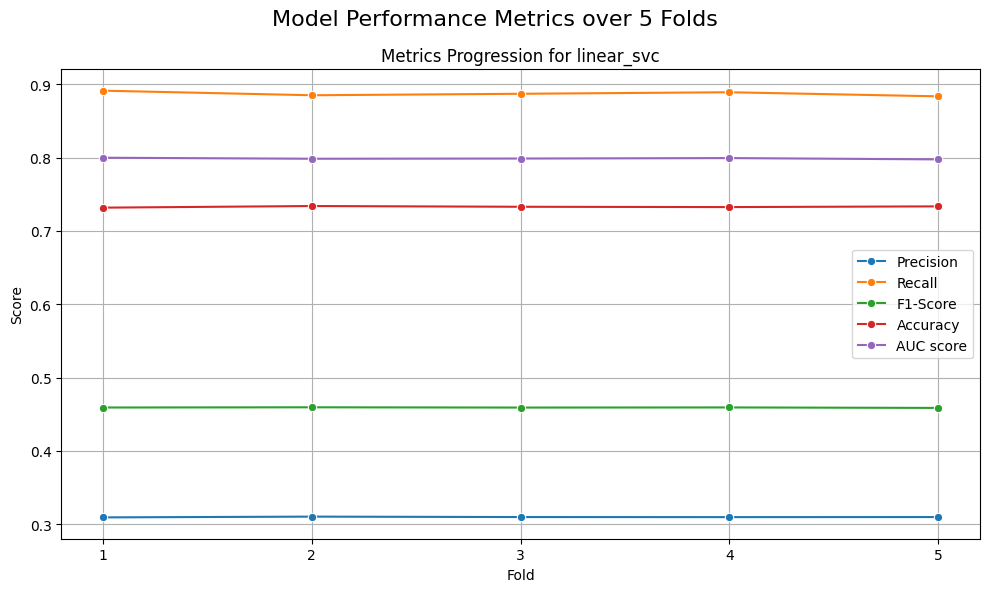

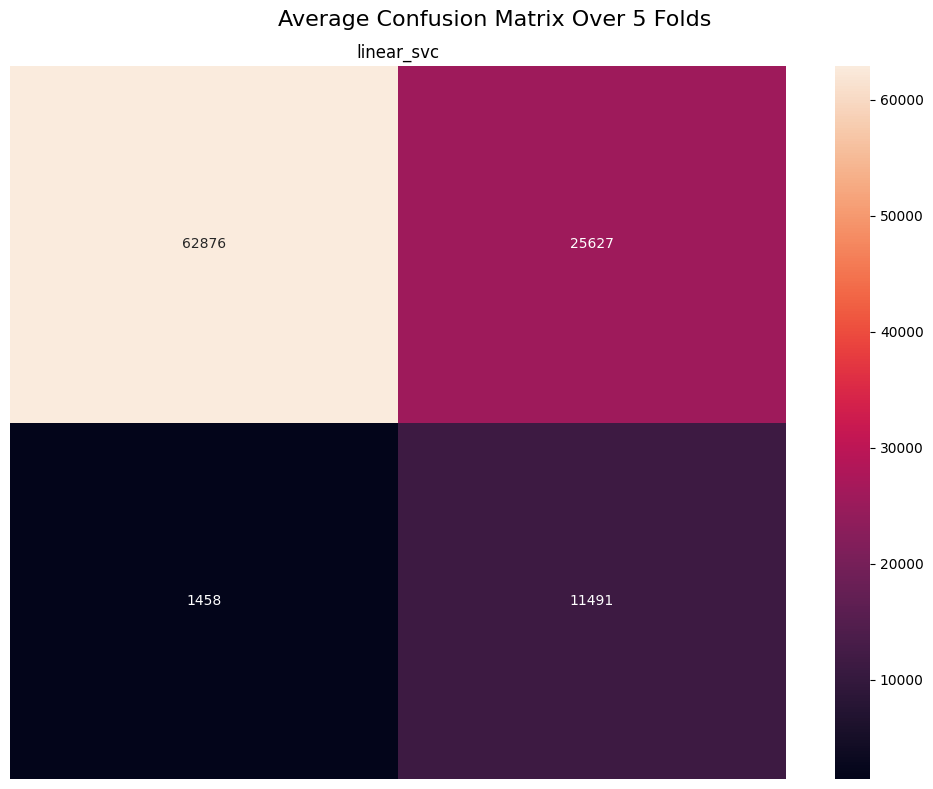

In [41]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

model_label = 'linear_svc'

svc_lin = LinearSVC(penalty='l2', class_weight='balanced', random_state=42, max_iter=10000)

svc_lin_param_grid = {
    'C': np.geomspace(1e-5, 1e-3, num=10),
}

svc_lin_kwargs = {
    'estimator': svc_lin, 'param_grid': svc_lin_param_grid, 
    'scoring': 'f1', 'n_jobs': -1}

num_folds = 5
sampling = 0
# for sampling in range(-1, 2):
svc_lin_scores, svc_lin_conf_mat, _ = train_test_results(
                                        df_=dfc_pca,
                                        num_folds=num_folds,
                                        test_size=0.3,
                                        model=GridSearchCV,
                                        label=model_label,
                                        sampling=sampling,
                                        **svc_lin_kwargs)

plot_performance_metrics(svc_lin_scores, num_folds=num_folds, sampling=sampling)
plot_confusion_matrix(svc_lin_conf_mat, num_folds=num_folds, sampling=sampling)